In [1]:
import numpy as np
from medpy.io import load
import matplotlib.pyplot as plt
from model.res_net import *
from evaluate import *
from scipy import ndimage
from skimage import measure
from skimage.transform import resize
from scipy.special import softmax

Using TensorFlow backend.


In [2]:
upper=250
lower=-200
model = ResNet50_FCN16_32col(NUM_CLASS=1)
model.load_weights('Experiments/liver_model/weights.80-0.944.h5')
tumor_model = ResUNet(NUM_CLASS=3)
tumor_model.load_weights('weight/tumor_model.h5')

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
image_list=[]
label_list=[]
pred_list=[]
for idx in range(5):
    image, h = load('../data_2/NTU/image/volume-'+str(idx)+'.nii')
    label, h = load('../data_2/NTU/label/segmentation-'+str(idx)+'.nii')
    image = image.transpose((2,0,1))
    label = label.transpose((2,0,1))
    image[image>upper]=upper
    image[image<lower]=lower
    image-=lower
    im = image.copy()
    im = np.float32(im)
    im = im/(upper-lower)
    image_list.append(im)
    label_list.append(label)
    ### liver stage
    thre=0.5
    rescale_size=256  
    if rescale_size!=512: 
        img = resize(image, (image.shape[0],rescale_size,rescale_size), order=3, mode='constant',
                     cval=0, clip=True,preserve_range=True)
    input_im = np.zeros(img.shape+(3,))
    for i in range(img.shape[0]):
        if i==0 or i==img.shape[0]-1: 
            input_im[i,:,:,0],input_im[i,:,:,1],input_im[i,:,:,2]=img[i],img[i],img[i]
        else: 
            input_im[i,:,:,0]=img[i-1]
            input_im[i,:,:,1]=img[i]
            input_im[i,:,:,2]=img[i+1]
    
    pred = model.predict(input_im)
    pred_liver = pred[:,:,:,NUM_CLASS-1]
    pred_liver[pred_liver>=thre]=1
    pred_liver[pred_liver<thre]=0
    
    # preserve the largest liver
    box=[]
    liver_dilation = pred_liver
    # liver_dilation = ndimage.binary_dilation(pred_liver, iterations=1).astype(int)
    [liver_biggest, num] = measure.label(liver_dilation, return_num=True)
    region = measure.regionprops(liver_biggest)
    for i in range(num):
        box.append(region[i].area)
    label_num = box.index(max(box)) + 1
    pred_liver[liver_biggest != label_num] = 0
    pred_liver[liver_biggest == label_num] = 1 

    if rescale_size!=512: 
        pred_liver = resize(pred_liver, (pred_liver.shape[0],512,512), order=0, mode='edge', 
                            cval=0, clip=True, preserve_range=True)
        pred_liver[pred_liver>=0.5]=1
        pred_liver[pred_liver<0.5]=0
    
    ### tunmor stage
    rescale_size=672
    thre=0.9
    if rescale_size!=512: 
        img = resize(img, (img.shape[0],rescale_size,rescale_size), order=3, mode='constant', 
                     cval=0, clip=True,preserve_range=True)

    input_im = np.zeros(image.shape+(3,))
    for i in range(image.shape[0]):
        if i==0 or i==image.shape[0]-1: 
            input_im[i,:,:,0],input_im[i,:,:,1],input_im[i,:,:,2]=image[i],image[i],image[i]
        else: 
            input_im[i,:,:,0]=image[i-1]
            input_im[i,:,:,1]=image[i]
            input_im[i,:,:,2]=image[i+1]
    pred = tumor_model.predict(input_im)
    pred = softmax(pred, axis=-1)
    pred_tumor = pred[:,:,:,2]
    pred_tumor*=pred_liver
    pred_tumor[pred_tumor>=thre]=1
    pred_tumor[pred_tumor<thre]=0
    if rescale_size!=512: 
        pred_tumor = resize(pred_tumor, (pred_tumor.shape[0],512,512), order=3, mode='constant', 
                            cval=0, clip=True,preserve_range=True)
        pred_tumor[pred_tumor>0.5]=1
        pred_tumor[pred_tumor<0.5]=0

    pred_list.append(pred_tumor)
    r = recall(pred_tumor, label)
    p = precision(pred_tumor, label)
    d = Dice(pred_tumor, label)
    print('Dice:',d)
    print('p:',p)
    print('r:',r)

c:\users\oplab\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Dice: 0.6670199617258082
p: 0.5640872436089416
r: 0.815903198721248
Dice: 4.854368696389869e-08
p: 4.854368696389869e-08
r: 1.0
Dice: 2.825656957260082e-09
p: 2.89100895376985e-09
r: 1.2499998437500196e-07
Dice: 0.7673234221064235
p: 0.6802882425610798
r: 0.8798961775838884
Dice: 0.19414204303127136
p: 0.1082369948639906
r: 0.9409547742402339


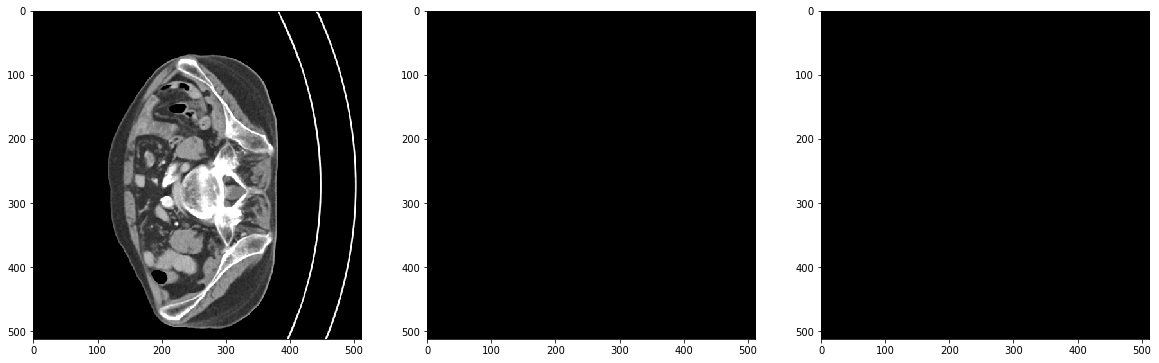

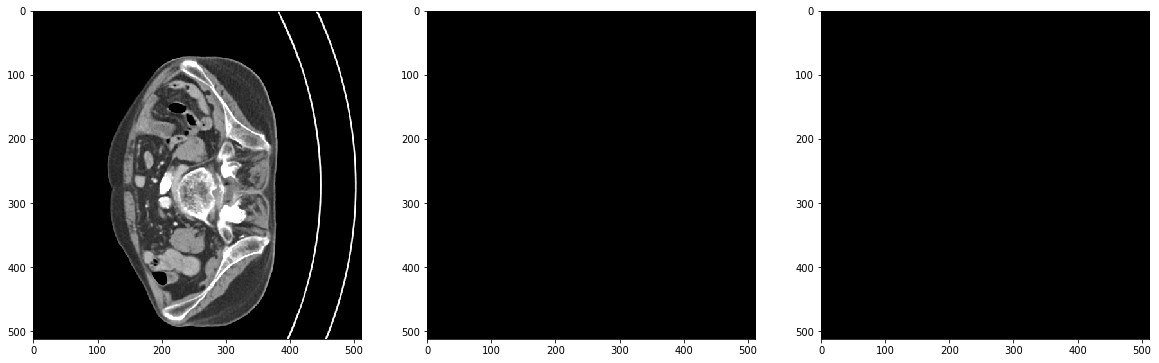

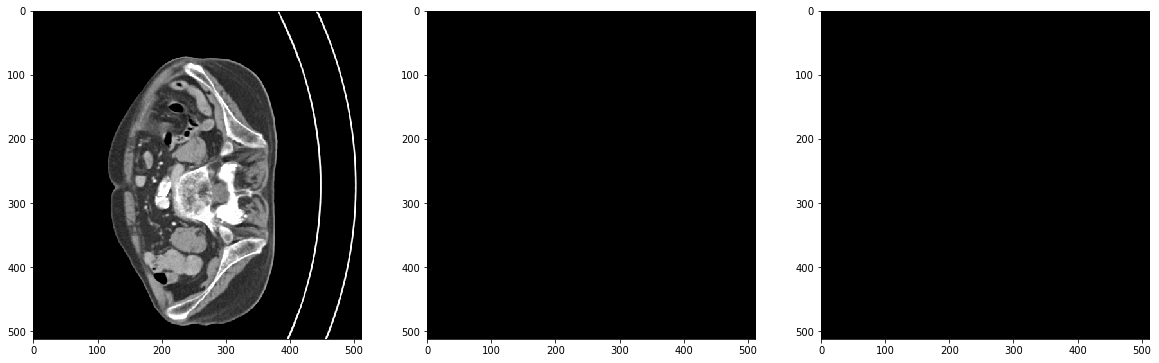

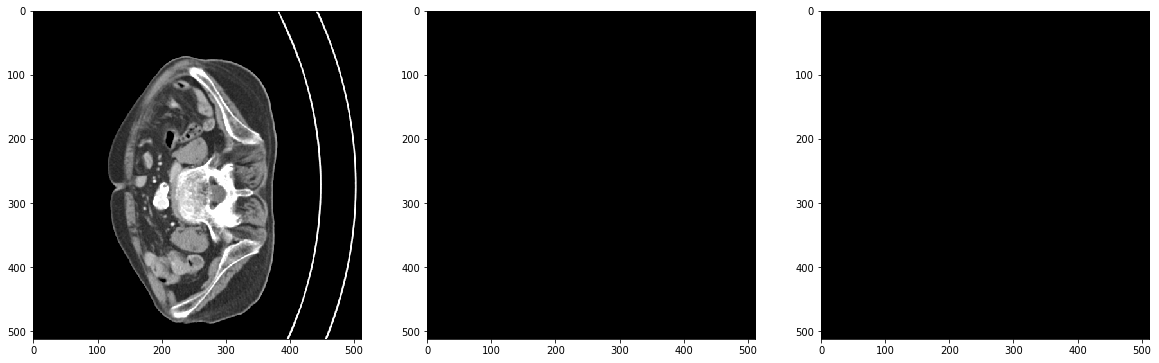

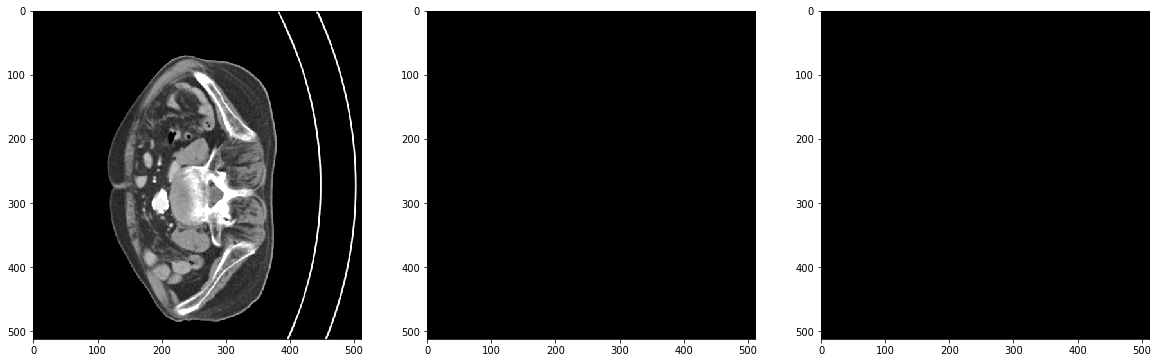

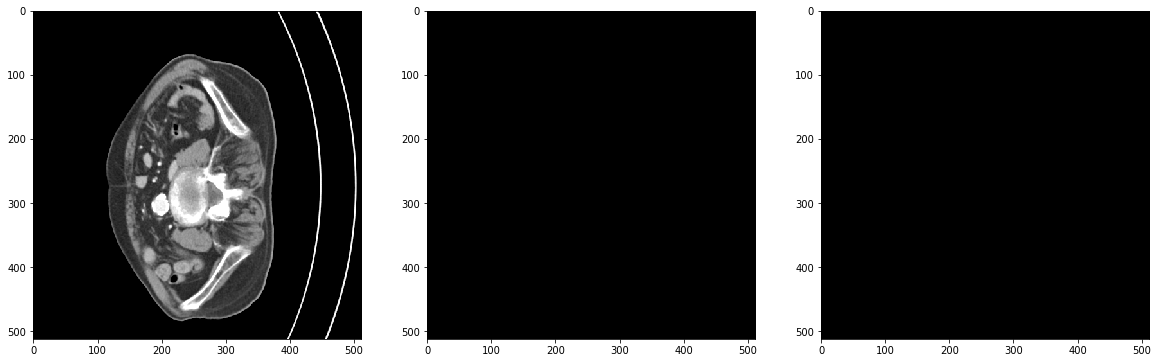

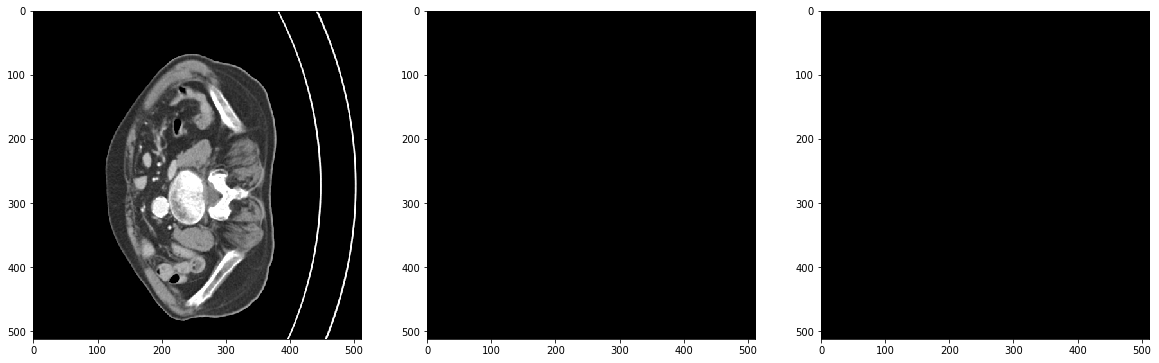

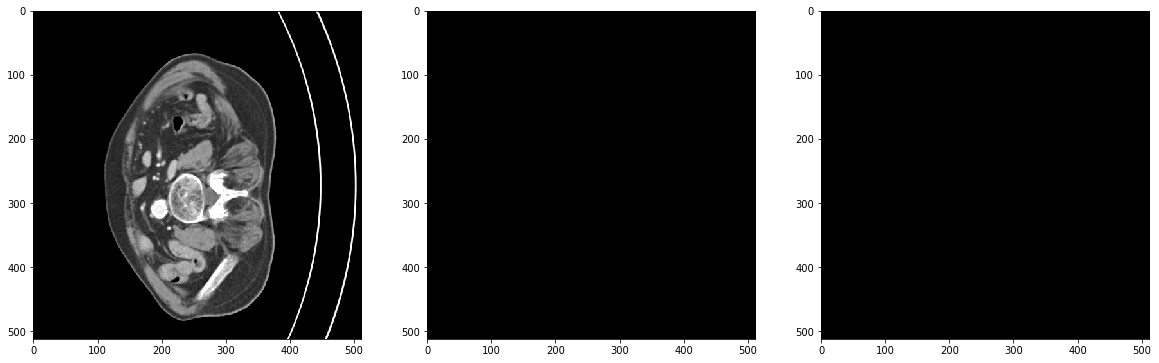

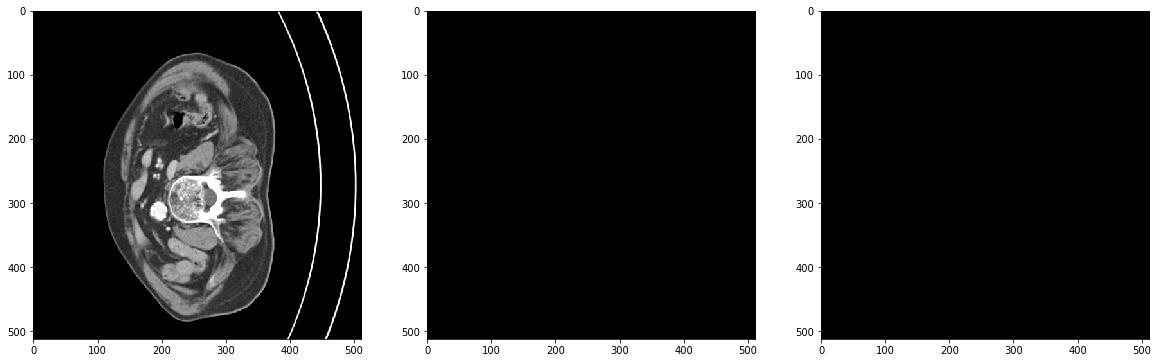

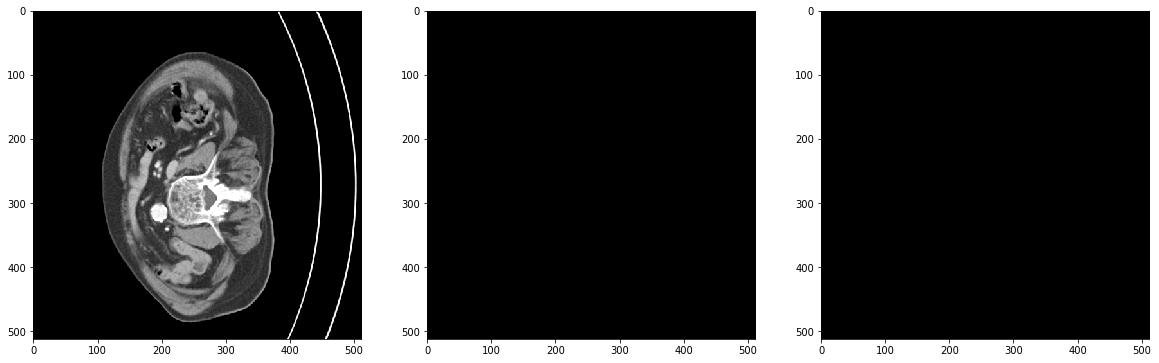

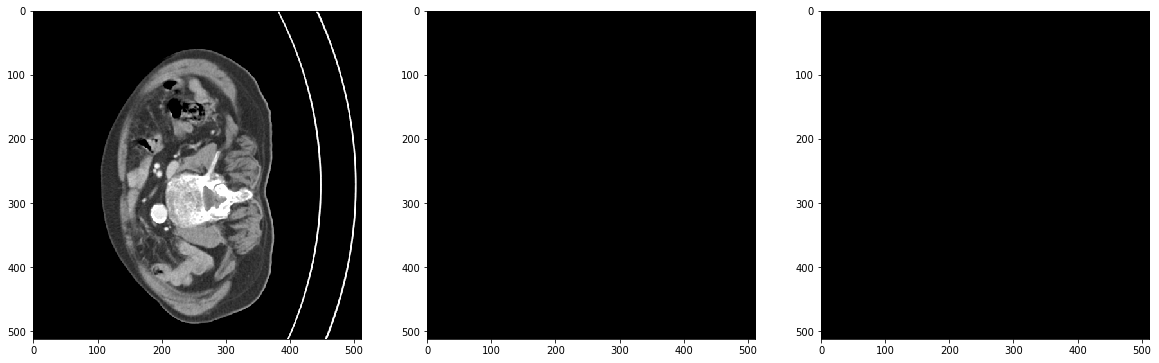

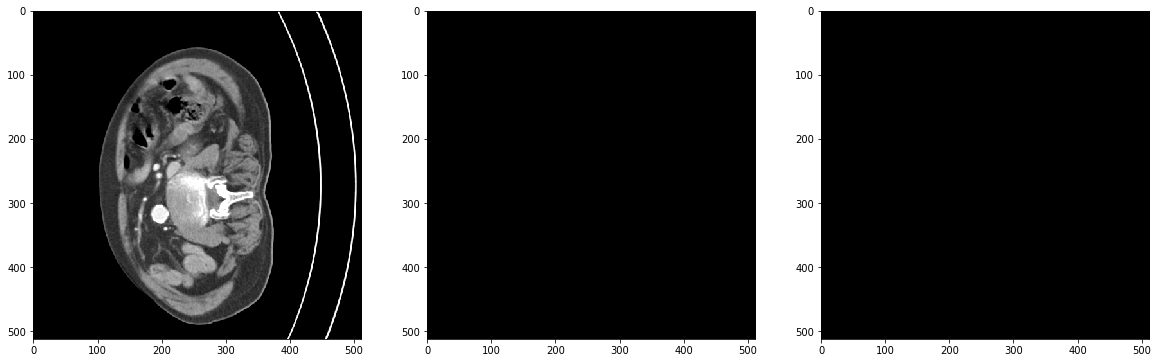

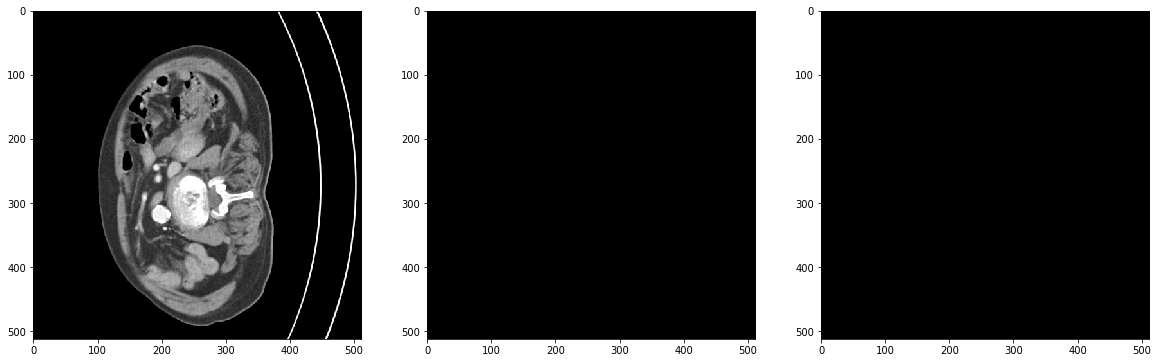

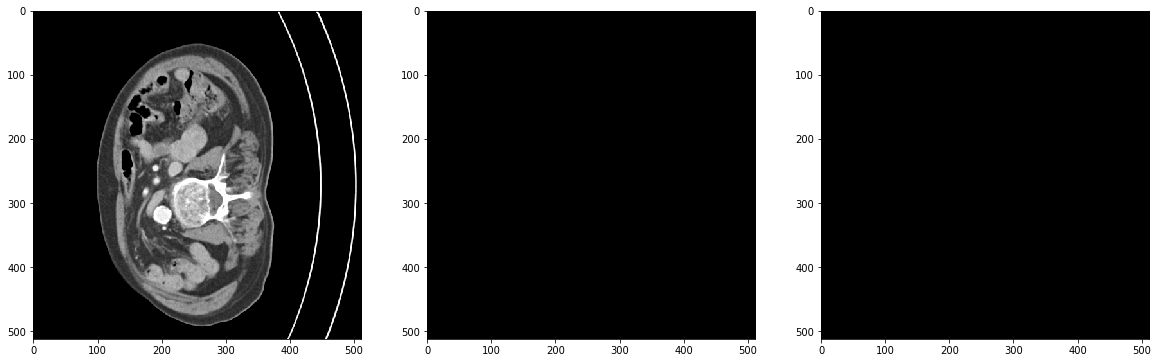

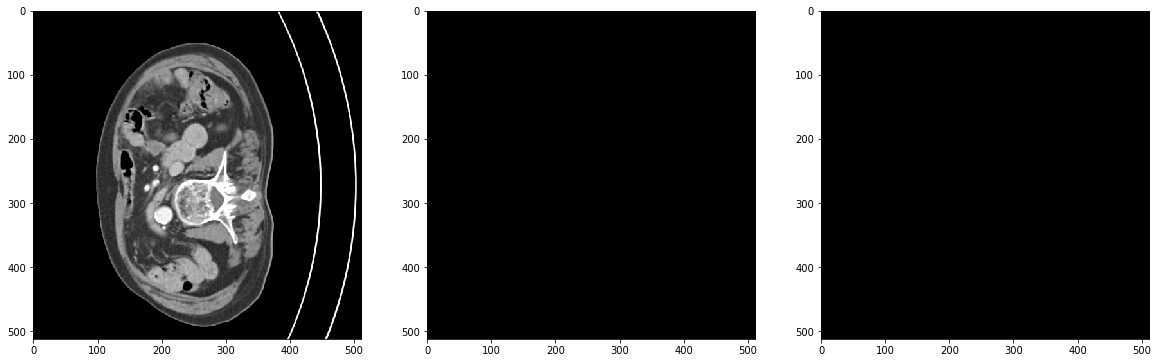

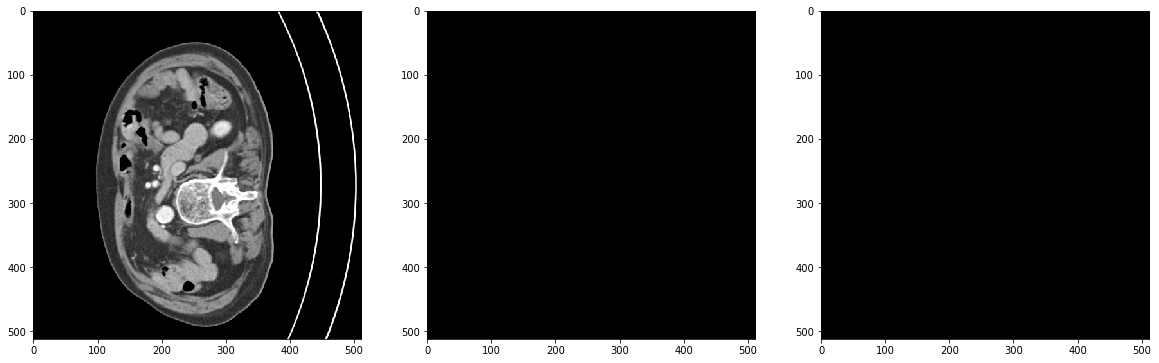

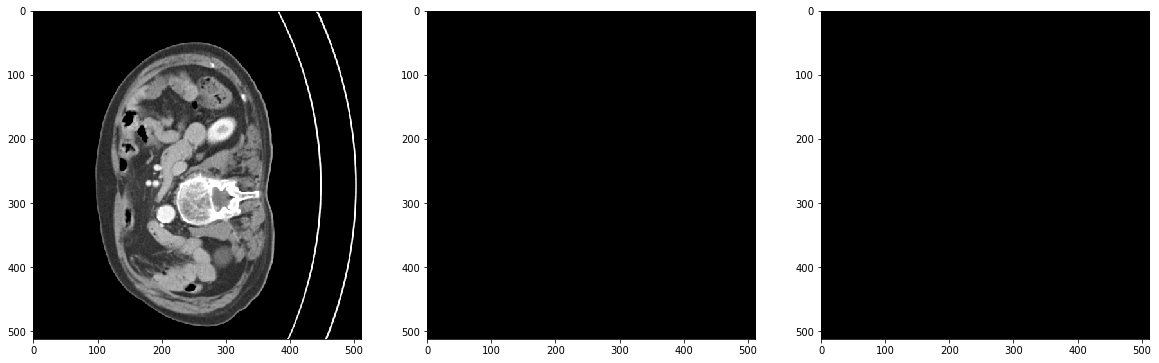

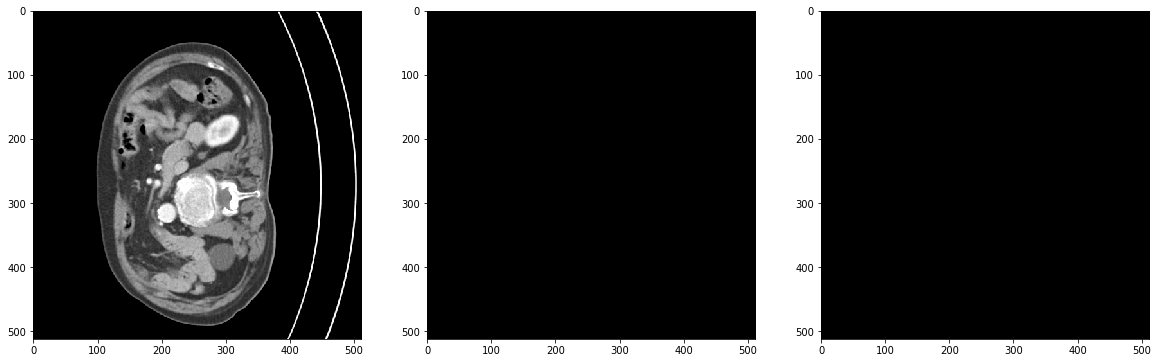

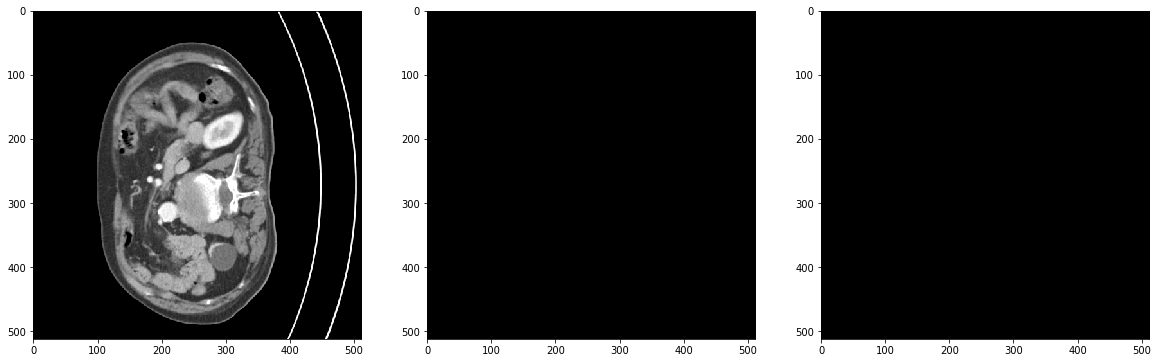

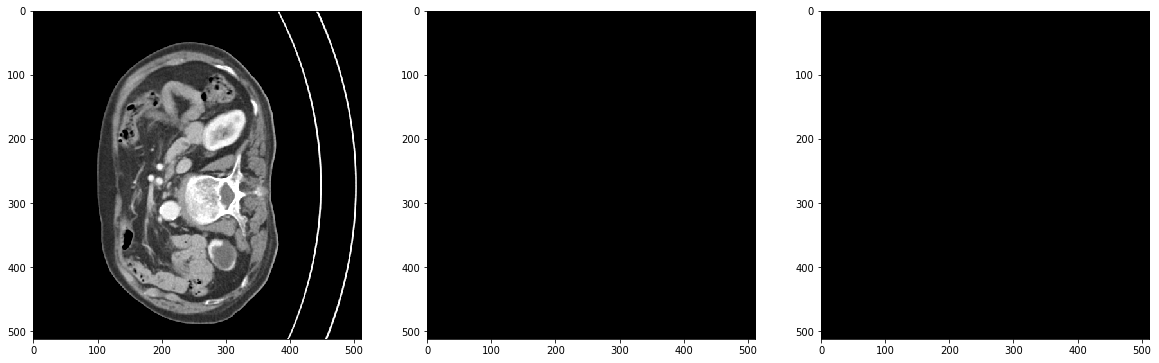

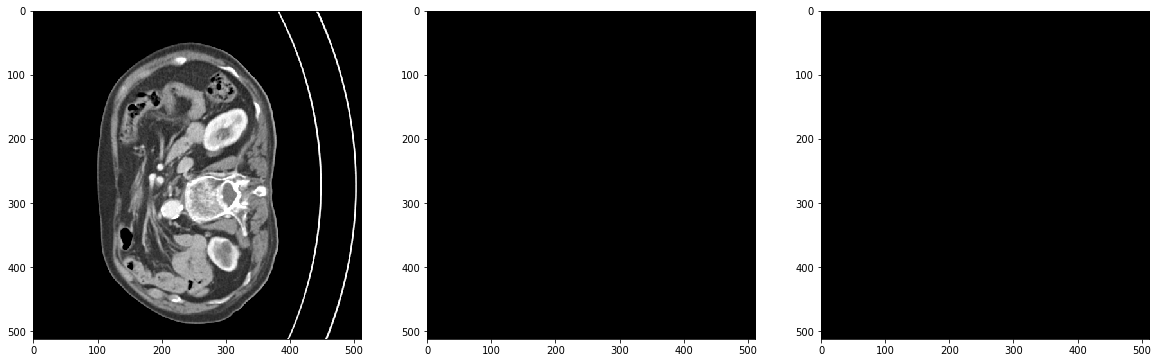

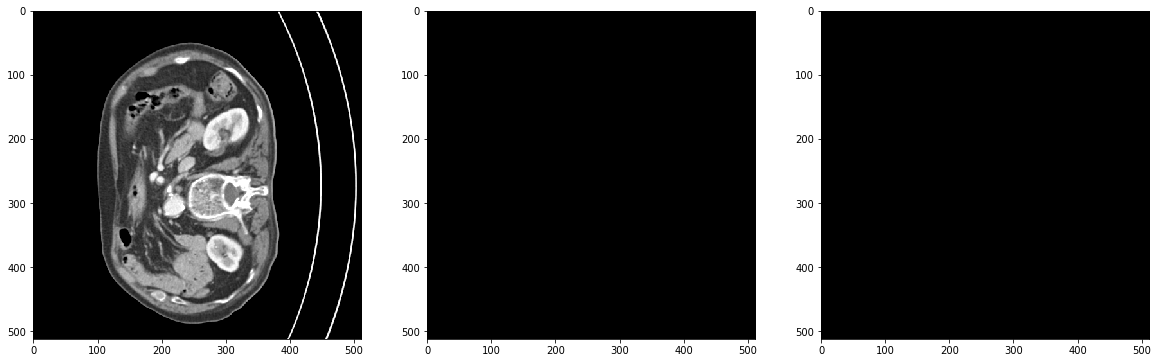

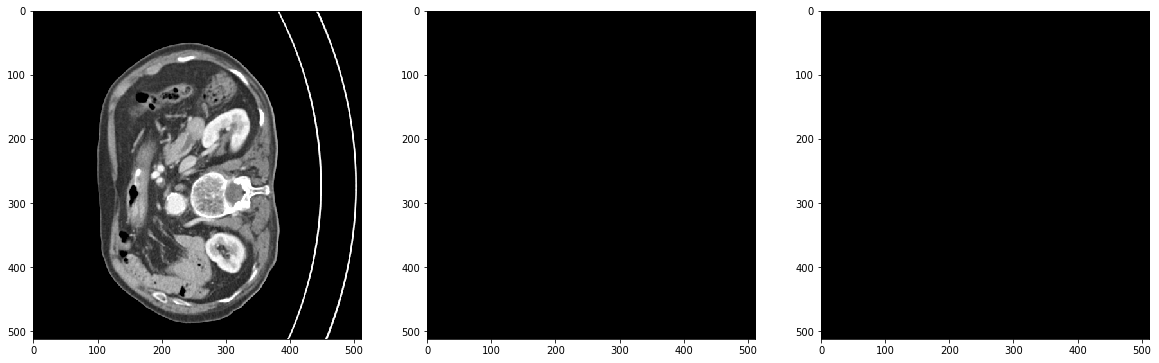

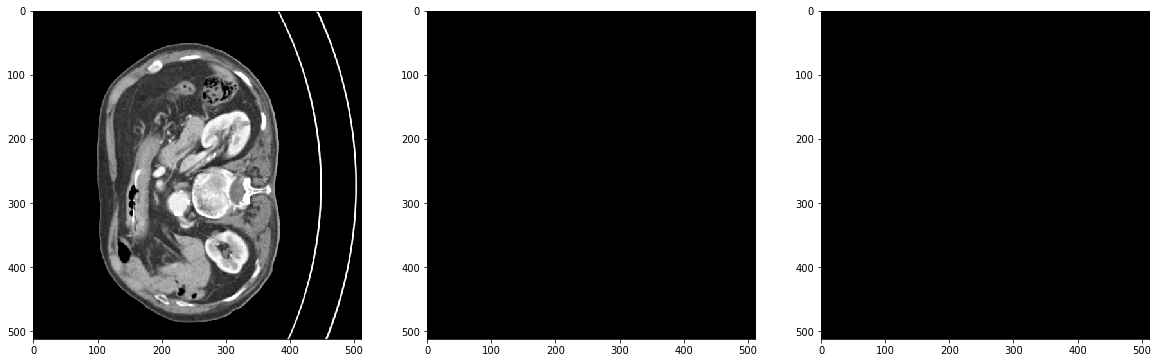

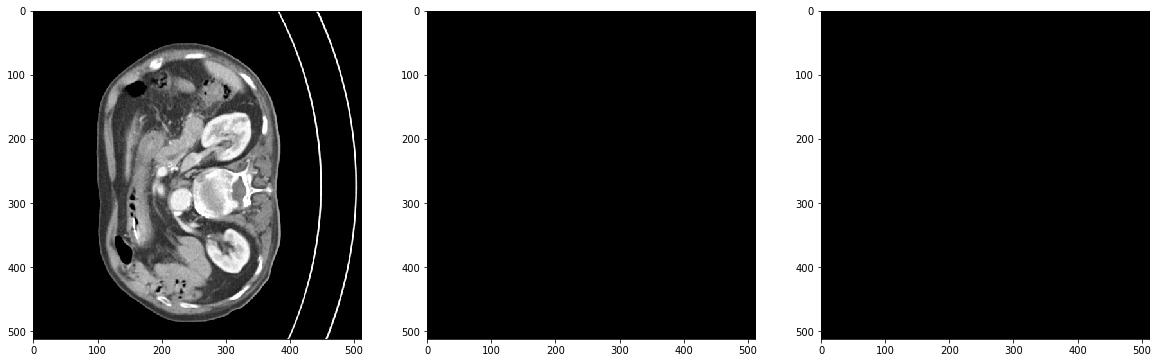

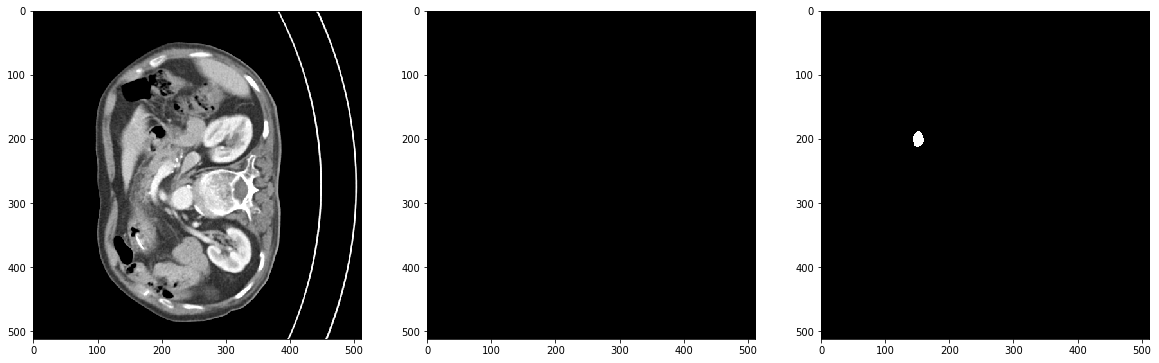

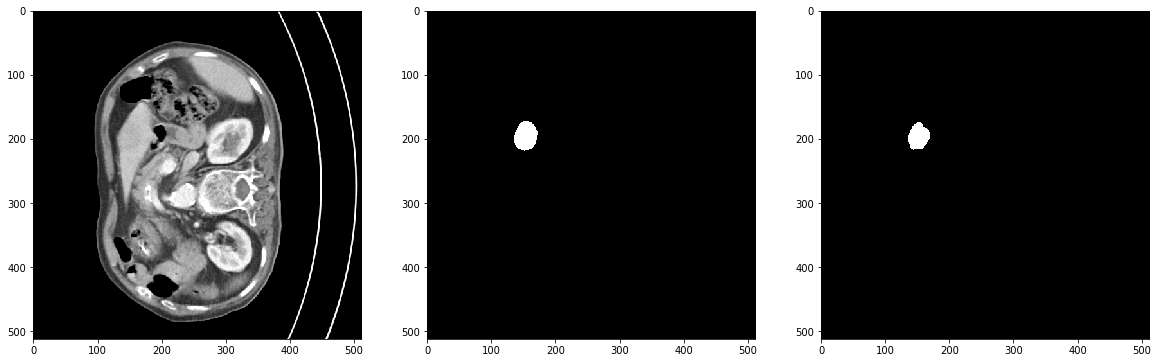

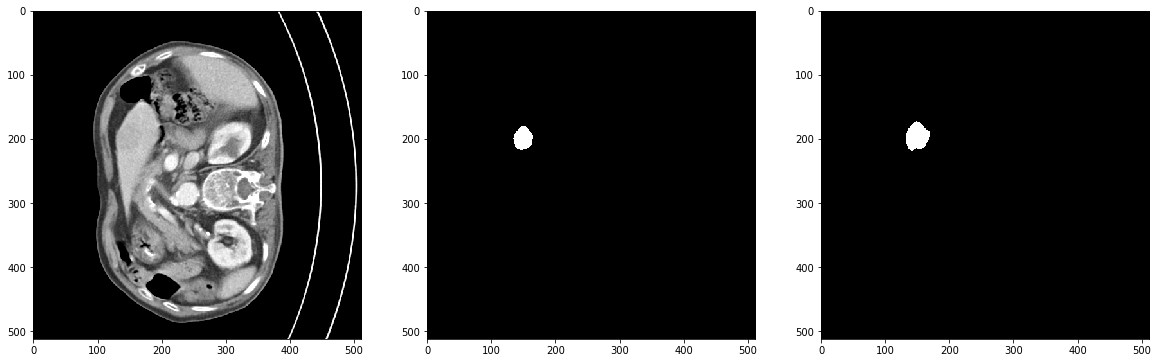

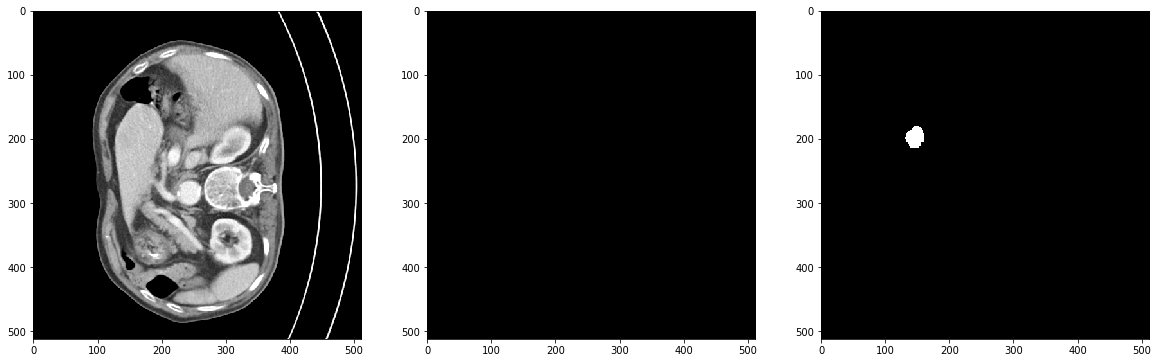

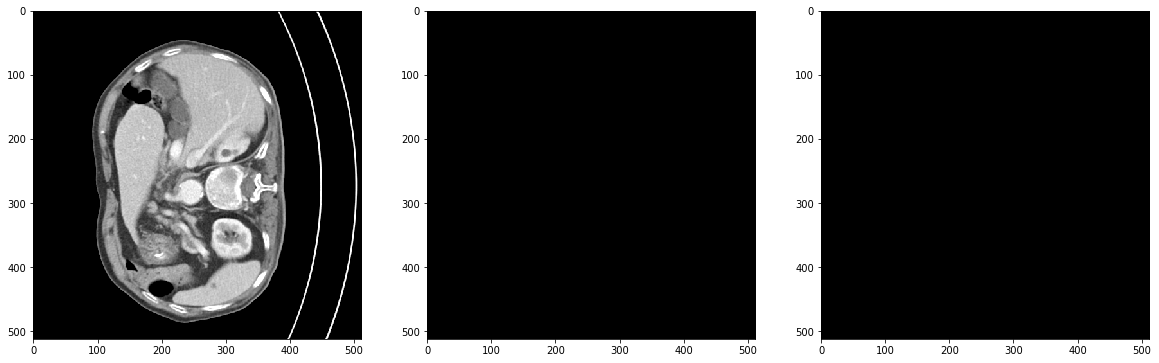

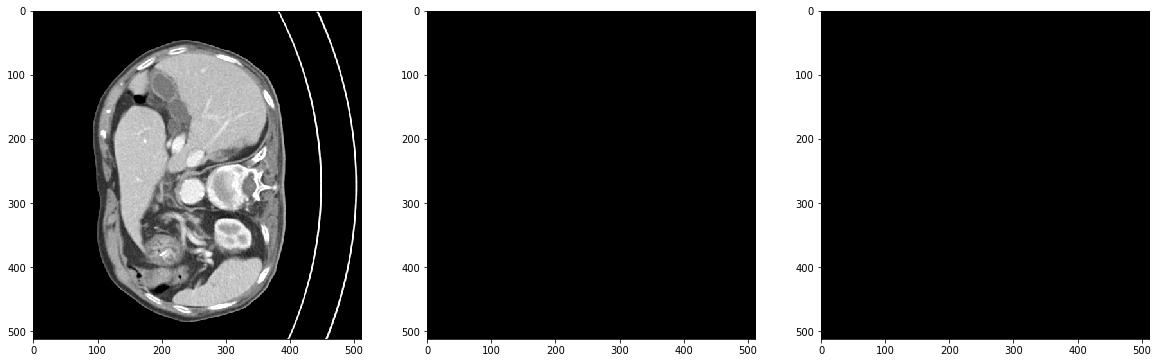

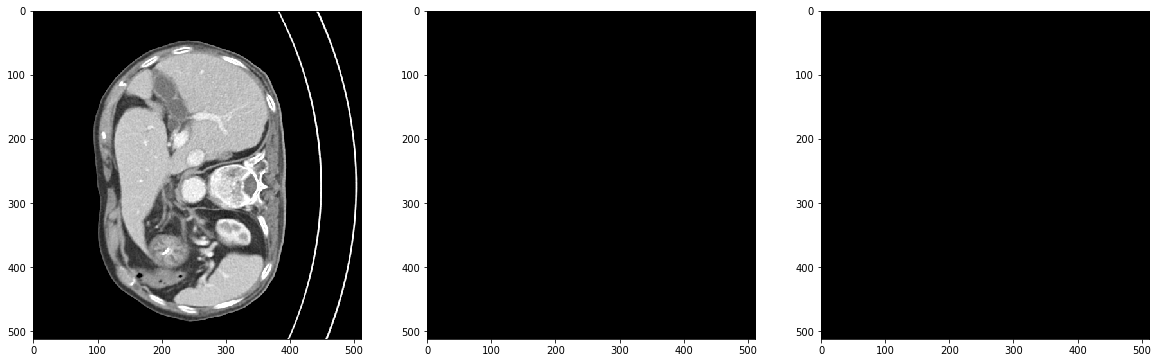

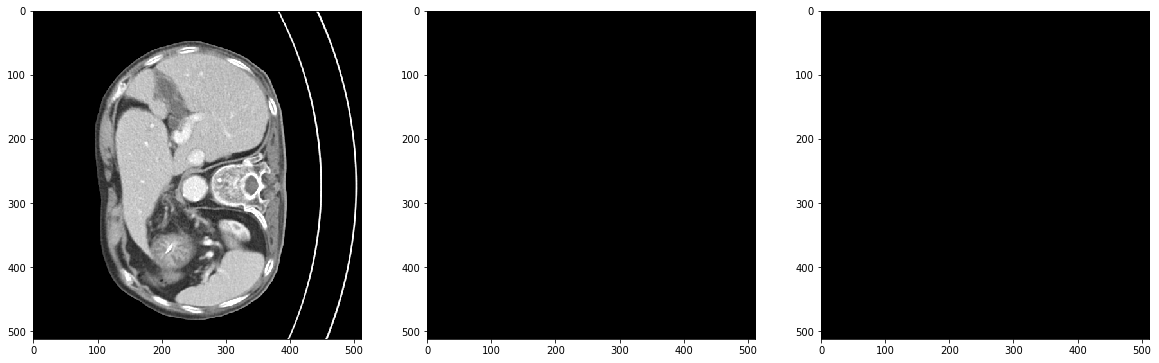

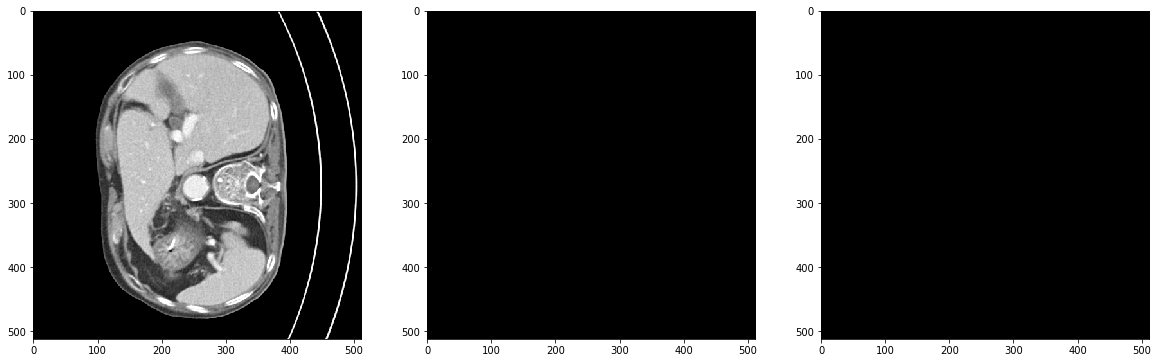

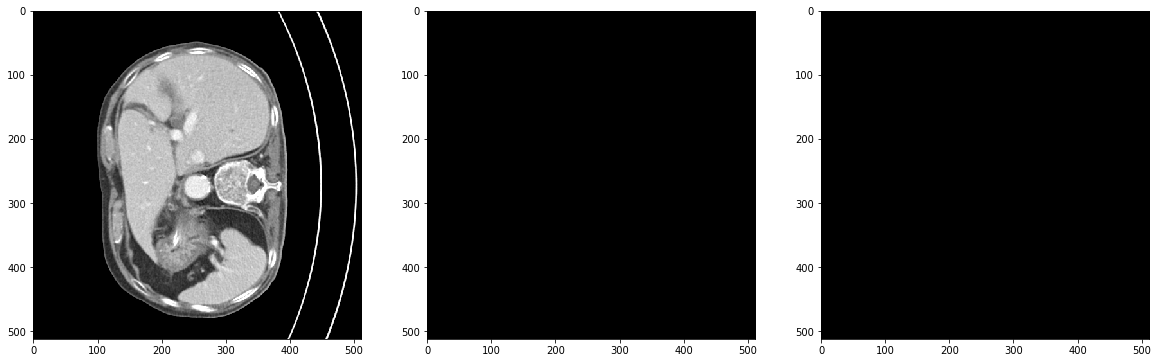

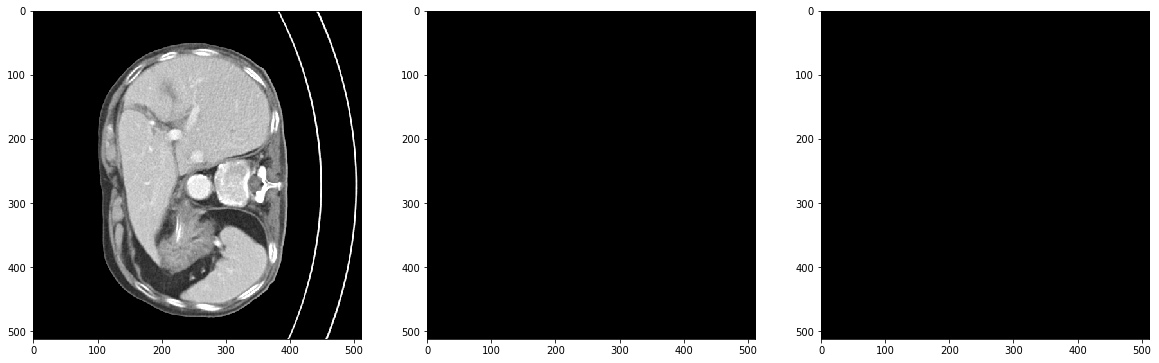

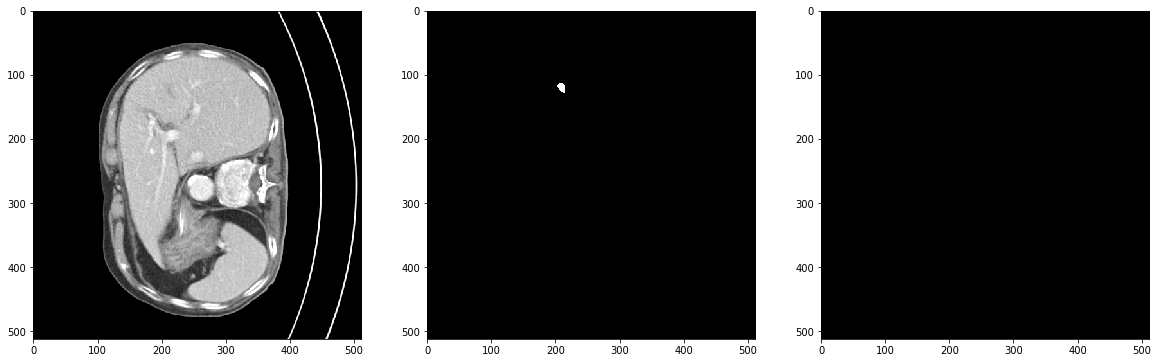

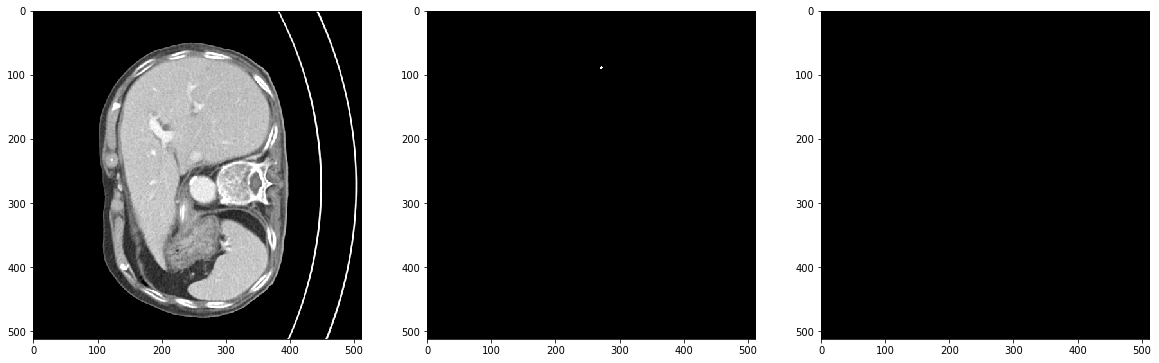

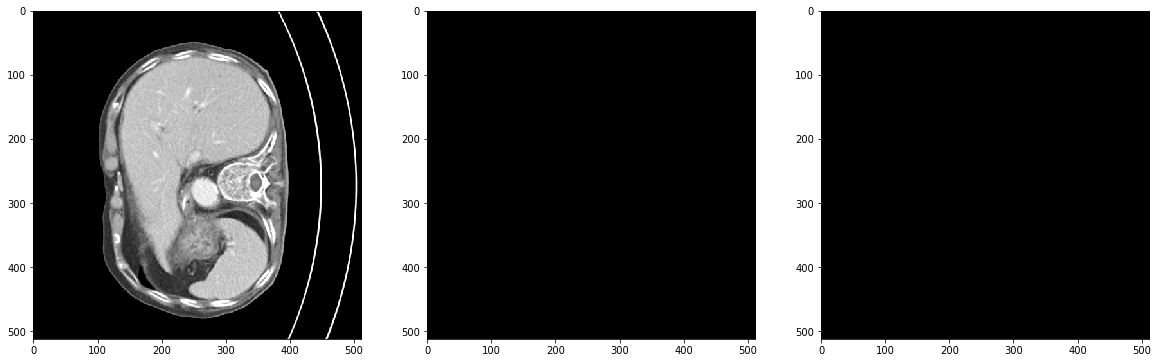

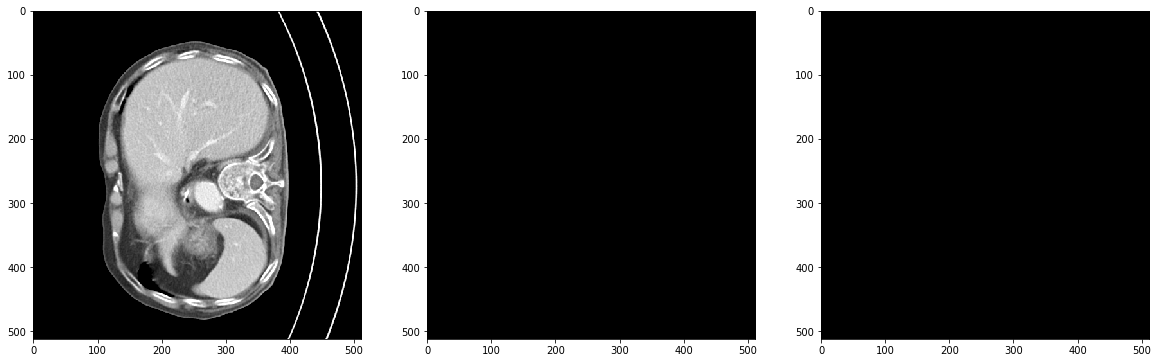

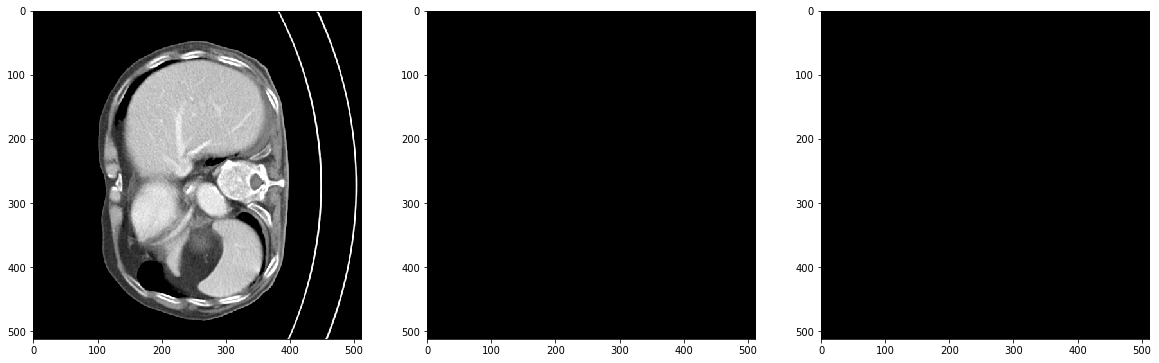

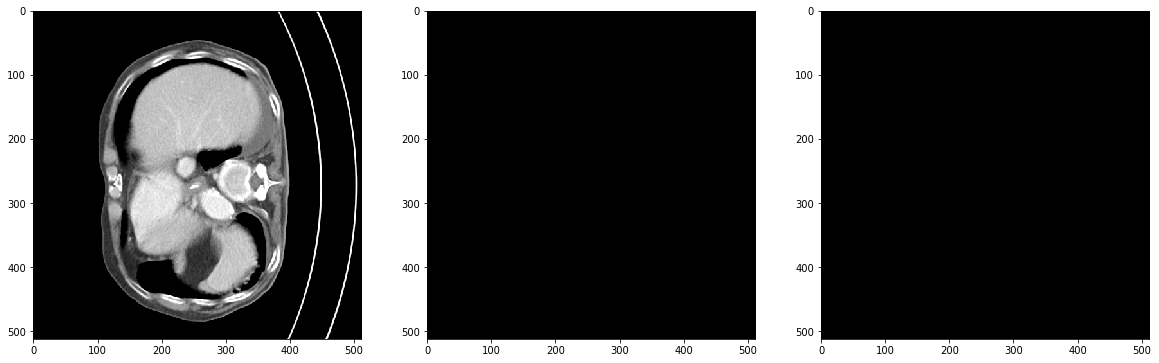

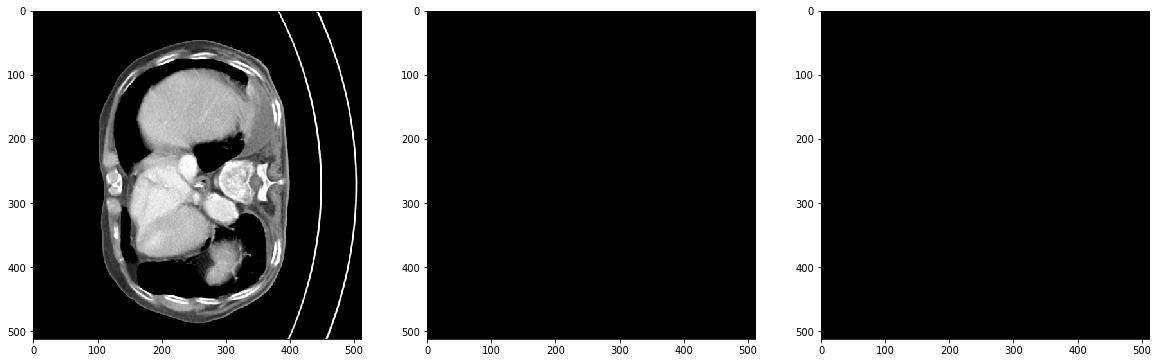

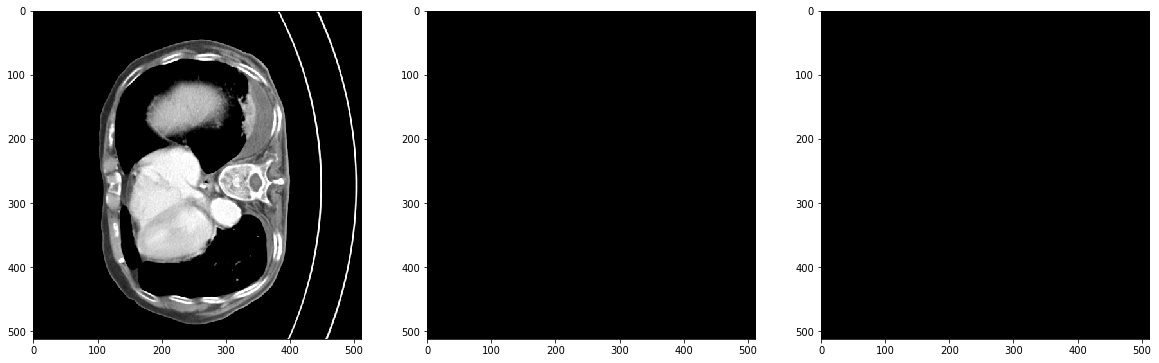

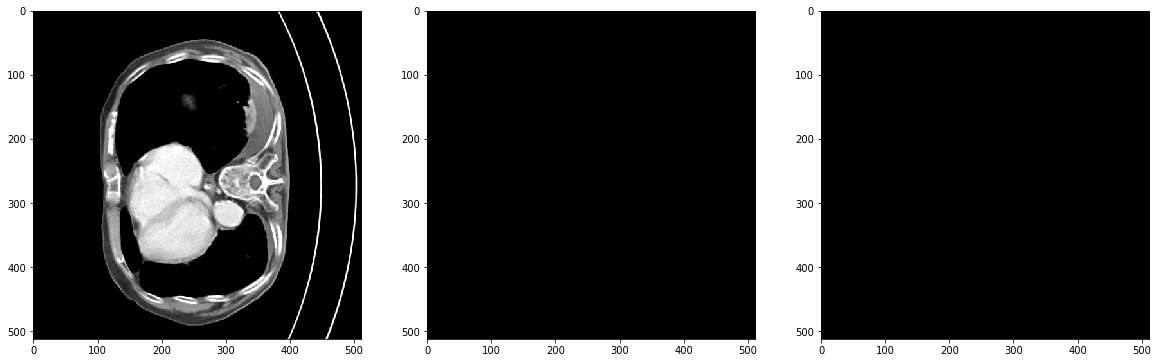

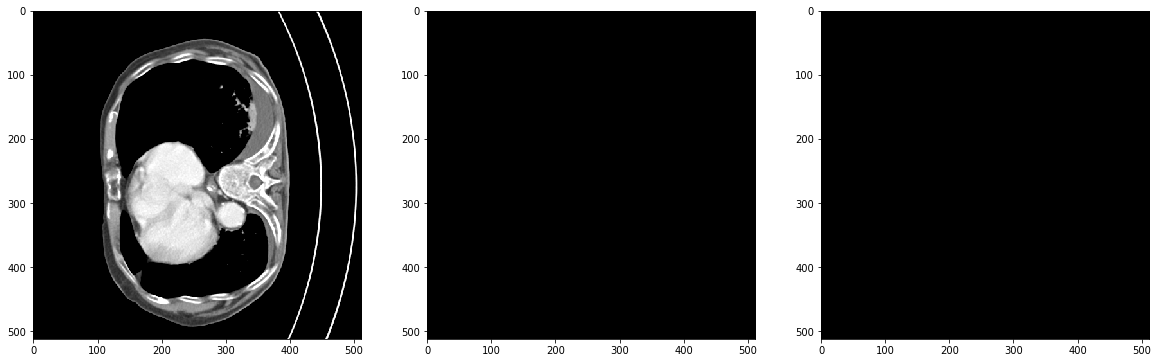

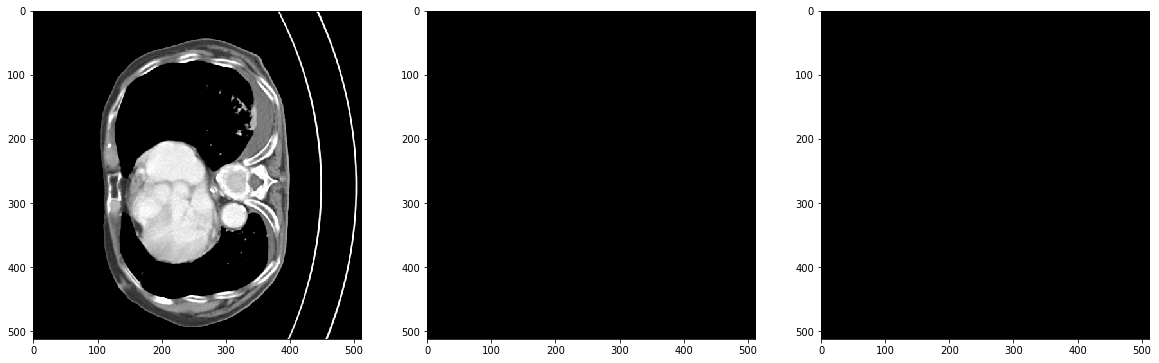

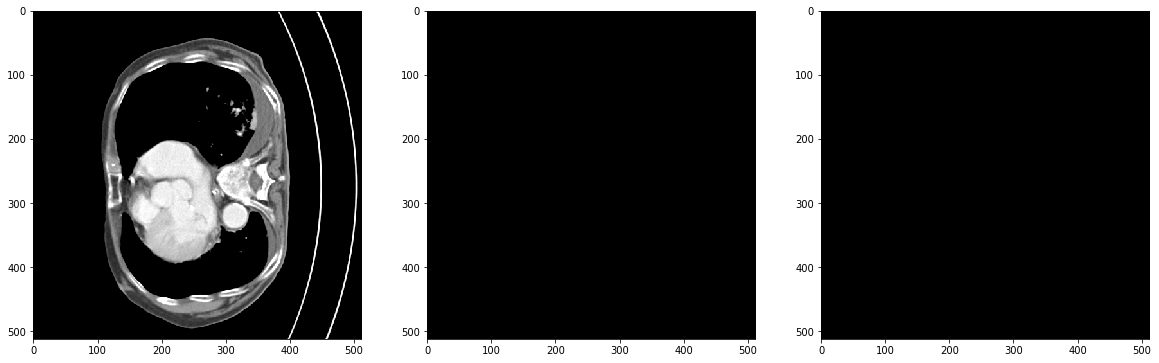

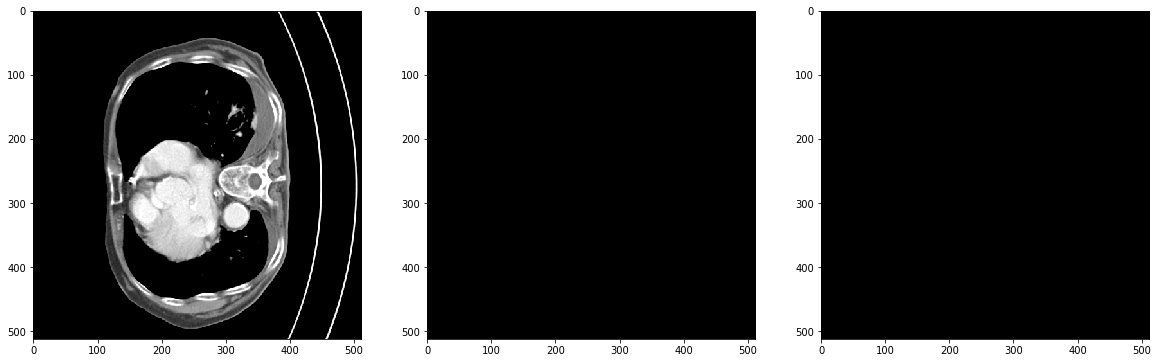

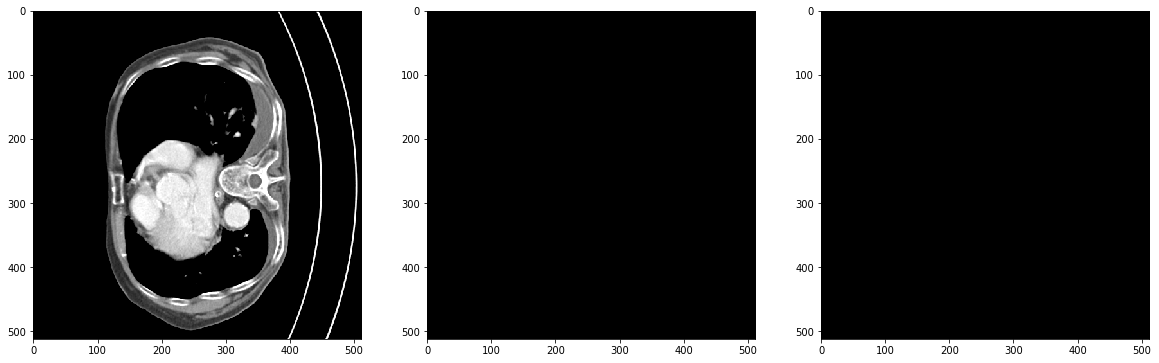

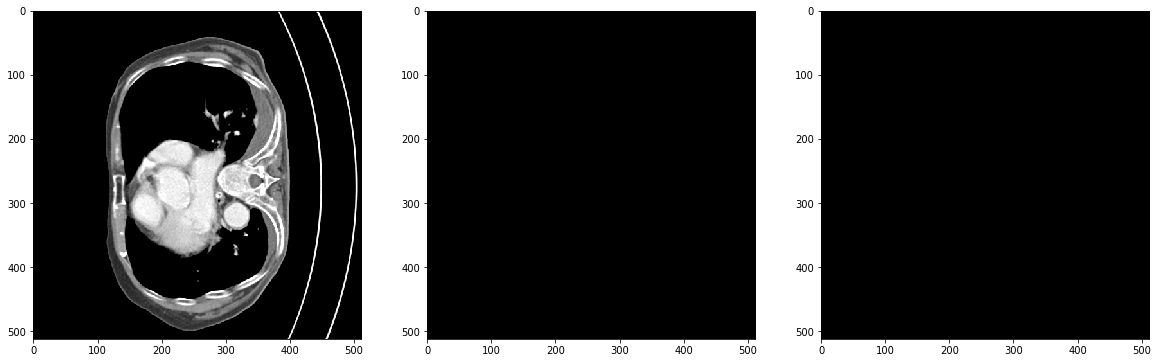

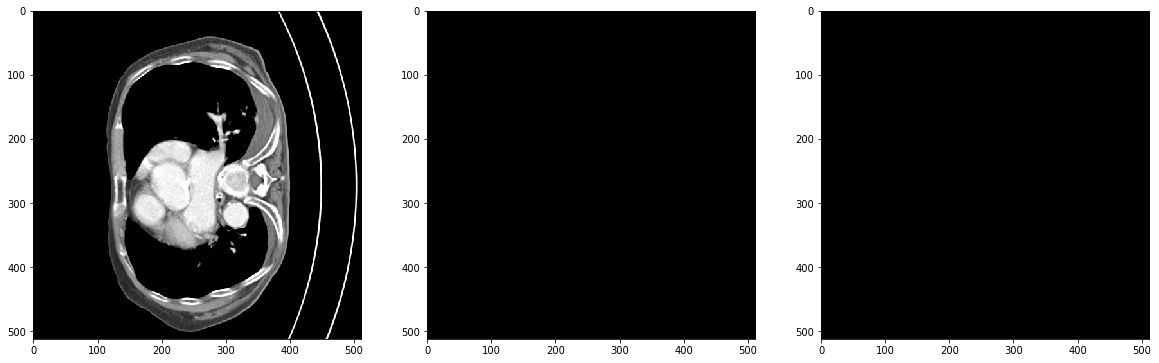

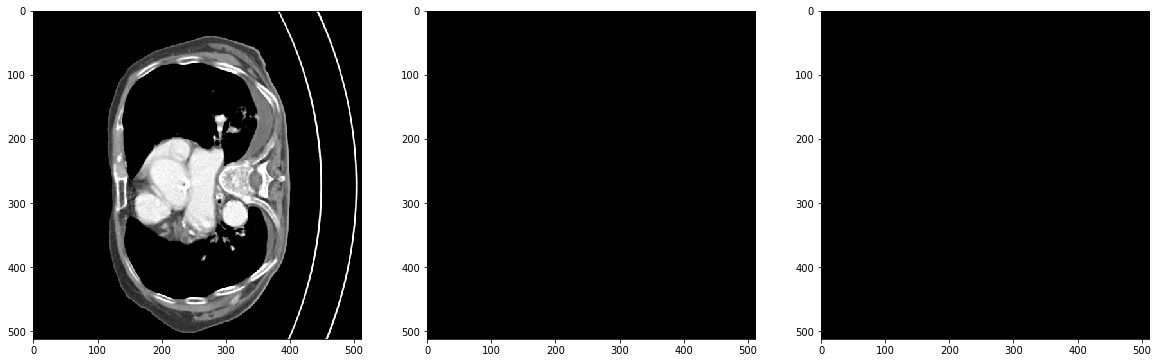

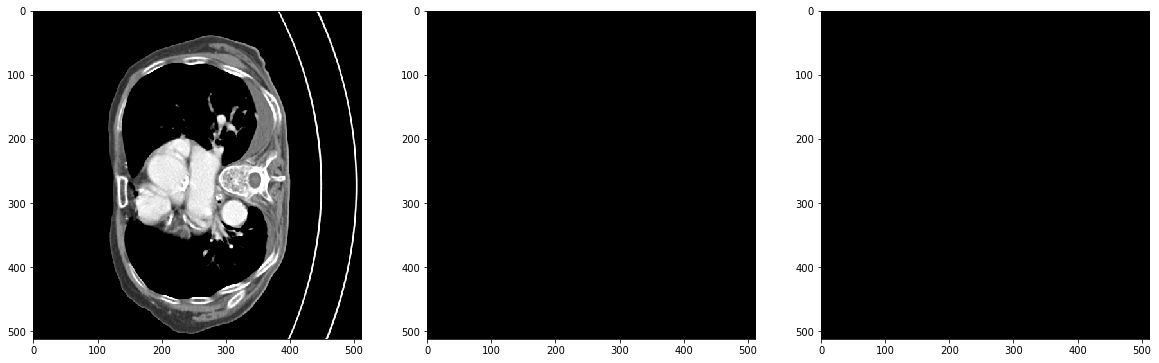

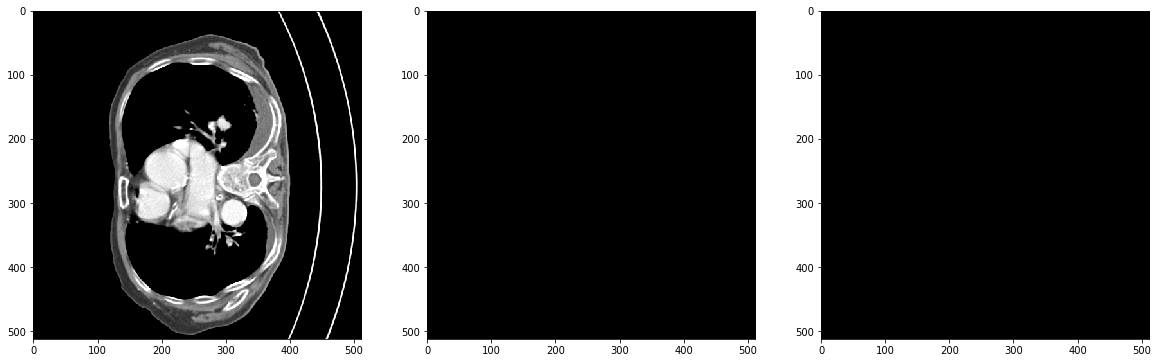

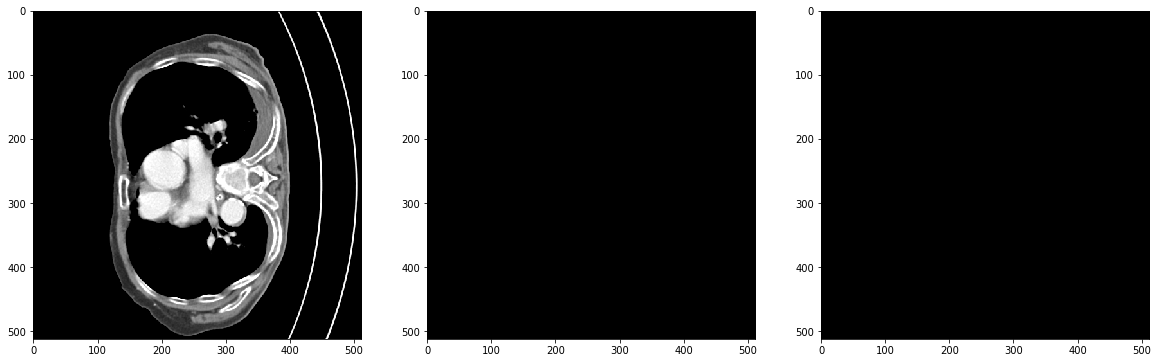

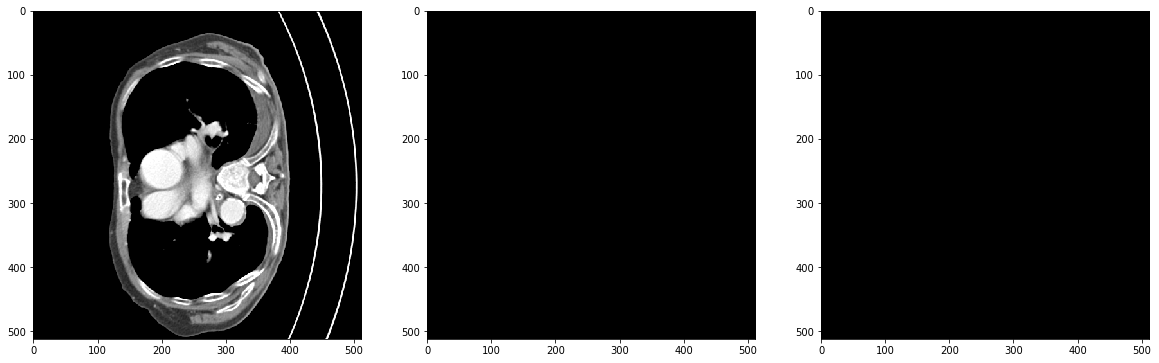

In [9]:
for i in range(label.shape[0]):
    fig = plt.figure(figsize=(20,20))
    plt.subplot(131)
    plt.imshow(im[i], cmap='gray')
    plt.subplot(132)
    plt.imshow(pred_tumor[i], cmap='gray')
    plt.subplot(133)
    plt.imshow(label[i], cmap='gray')
    plt.show()